"Descent into Collective Entanglement"

This thesis work is to explore the possibility of faster calculations for calculating "Collectibility" for a given density matrix for a given multipartite system. In this work, we mainly focus on the 3*3 system.

We we wilm be trying out gradient descent algorithms for the purpose of finding the optimum "separable state set" to get a minimum value of collectibility. This minima, in return, will indicate if the system is entangled.

We will start with testing on known classes of density matrices (eg, werner states) which have known bounds as a sanity check of the approach.

Steps - 
1. Function working with unitary matrix. It will have a function to calculate random unitary matrix using Zyczkowski's method. ✅
2. Moreover, it needs to calculate the partial differential of U wrt an individual parameter. And then return the gradient for the whole parameters vector. ✅
3. Decide on the step size.✅
4. Work on generating density matrices - Random Density matrices and werner states.✅
5. Work out the collectibility function for given parameters.✅
6. After calling the gradient calculating function and deciding on the step size, we calculate the value of Collectibility for the next step.✅
7. We find the local minima, and do this procedure more times, to search fort he global minima.
8. Visualize the results for plotting graphs and getting a visual sense of the work.
9. Compare with brute force methods by searching for the optimum solution (minima) by random search.

In [424]:
# Library imports

import random
import cmath,math
from pprint import pprint
import copy
import time
import itertools

#numpy and matplot
import matplotlib.pyplot as plt
import numpy as np

#Qutip imports
from qutip import (Qobj, about, basis, coherent, coherent_dm, create, 
                  destroy,expect, fock, fock_dm, mesolve, qeye, sigmax, 
                  sigmay,sigmaz, tensor, thermal_dm,dimensions,
                  rand_dm,rand_unitary,partial_transpose,
                  hadamard_transform,projection,phase_basis)

import qutip

from functools import reduce

In [527]:
# List of intial states - 

#Random rho generator - using banacki's method (and maybe using Qobj)
def Mutually_Orthogonal_state_generator(system):
    '''
    Initially, the assumption is that all Hilbert spaces of the subsystem are of 
    the same dimension.
    Should I pad the lower dimension subsystems with zero columns??
    '''
    N = min(system)
    MO_Basis_set = []
    for subsys_dim in system:
        MO_Basis_subset = [basis(subsys_dim, n) for n in range(subsys_dim)]
        MO_Basis_set.append(MO_Basis_subset)
    return MO_Basis_set

def Seperable_state_set_generator(MO_Basis_set):
    #Initially, the assumption is that all Hilbert spaces of the subsystem are of 
    # the same dimension.
    
    Seperable_basis_set = []
    N = max([len(subsys) for subsys in MO_Basis_set])
    for n in range(N): 
        Seperable_basis_set.append(tensor([subsys[n] for subsys in MO_Basis_set]))
    return Seperable_basis_set

system = [3,3]        
Sep_state_set = Seperable_state_set_generator(Mutually_Orthogonal_state_generator(system))
print(Sep_state_set)

[Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]], Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]]


In [845]:
# Generating rho (random and werner)
# Generating Random Density Matrices - few options - 

# 1. Random Density matrix using built in Qutip functions - 
rand_dm(size)

# 2. Generating Werner State

def Probability_generator(n):
    '''
    Generates list of Probabilites with n elements, for by partitioning 1 with each step. 
    Hence, adding up to 1.
    '''
    Probs = []
    limit = 1
    for i in range(n-1):
        p = random.uniform(0,limit)
        limit = limit - p
        Probs.append(p)
    Probs.append(limit)
    return Probs

def Probability_generator1(n):
    '''
    Generates list of Probabilites with n elements, by first generating n-1 probabilities.
    Then sorting them, add 0 and 1 to the list and we get list of Pobabilities that add up to 1 by taking difference 
    between elements of the previous list. Suggested by Dr. Banacki.
    '''
    
    Probs = []
    for i in range(n-1):
        R = random.uniform(0,1)
        if R not in [0,1]:
            Probs.append(R)
    Probs = sorted(Probs+[0,1])
    Probabilities = []
    for j in range(n):
        Probabilities.append(Probs[j+1]-Probs[j]) 
    return Probabilities

def Simplex_generator(n):
    P = Probability_generator1(n)
    simplex = np.identity(n)
    for i in range(n):
        simplex[i,i] = P[i]
    simplex = Qobj(simplex)
    return simplex

def Amplitude_Generator(Probs):
    for i in range(len(Probs)):
        Probs[i] = math.sqrt(Probs[i])
    return Probs

def Normalized_pure_state_generator(dim):
    simplex = Amplitude_Generator(Probability_generator1(dim))
    Q = [basis(dim, n) for n in range(dim)]
    NPS = []
    for i in range(dim):
        W = simplex[i]*Qobj(dimensions.collapse_dims_oper(tensor([Q[i],Q[i]])))
        NPS.append(W)
    NPS = sum(NPS)
    return(NPS)

def Arbitrary_Mixed_State(n):
    simplex = Simplex_generator(n)
    U = rand_unitary(n)
    AMS = U*simplex*U.dag()
    return AMS 

def Reshaping_Qobj(Q,subsys):
    K = len(subsys)
    N = np.prod(np.array(subsys))
    if N != Q.shape[0]:
        raise ValueError("Product of dimensions of subsystem and Total dimension of Qobj dont match")
    Q.dims = [subsys for i in range(len(subsys))]
    return Q
    
def Werner_Density_Matrix(dim,alpha):
    '''
    For an dim*dim system, Werner state is given as -
    l
    NPS = Normalized Pure State
    '''
    NPS = Normalized_pure_state_generator(dim)
    UV = tensor(rand_unitary(dim),rand_unitary(dim))
    print(UV)
    rho = alpha*UV*NPS*NPS.dag()*UV.dag() + (1-alpha)/(dim**2)*qeye(dim**2)
    return rho

# print(Werner_Density_Matrix(3,0.5))
AMS = Arbitrary_Mixed_State(6)
AMS = Reshaping_Qobj(AMS,[2,3])
print(AMS)
# partial_transpose(AMS, [False,True]).eigenenergies()

Quantum object: dims = [[2, 3], [2, 3]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[ 0.1284825 +0.j          0.00538368-0.00156239j -0.00153526+0.04345432j
   0.04887881-0.0183226j   0.04766012+0.03152787j -0.02238642-0.00509206j]
 [ 0.00538368+0.00156239j  0.18360002+0.j          0.04147596+0.00865449j
   0.06803382-0.05549544j -0.00106001-0.03048298j -0.0283046 +0.0012352j ]
 [-0.00153526-0.04345432j  0.04147596-0.00865449j  0.18970316+0.j
   0.03996976-0.03818998j -0.03420397+0.02368508j -0.00748452+0.01125574j]
 [ 0.04887881+0.0183226j   0.06803382+0.05549544j  0.03996976+0.03818998j
   0.21071283+0.j         -0.02809816-0.03148609j -0.02855019-0.00806061j]
 [ 0.04766012-0.03152787j -0.00106001+0.03048298j -0.03420397-0.02368508j
  -0.02809816+0.03148609j  0.11208924+0.j          0.03647573-0.00229162j]
 [-0.02238642+0.00509206j -0.0283046 -0.0012352j  -0.00748452-0.01125574j
  -0.02855019+0.00806061j  0.03647573+0.00229162j  0.17541225+0.j        ]]


In [427]:
# Helper function 1
'''
Helper functions - 
all the function that can be used across multiple modules 
and repeatedly often.
''' 

def generate_alpha(delta):
    alpha = random.uniform(0,2*cmath.pi*delta)
    return alpha

def generate_phi(r,s,delta):
    Xi = random.uniform(0,delta)
    phi = math.asin(Xi**(1/(2*r)))
    return phi

def generate_psi(r,s,delta):
    psi = random.uniform(0,2*cmath.pi*delta)
    return psi

def generate_chi(r,s,delta):
    chi = random.uniform(0,2*cmath.pi*delta)
    return chi

def para_i(r,s):
    return (s**2-2*r-1, s**2-2*r, (s+1)**2-2*(s+1)) 

In [428]:
# Helper functions 2

def Series_multiply(lst, order = 'normal'):
    Multiplied_list = []
    M = 1
    
    if order=='right':
        lst1 = lst.copy()
        lst1.reverse()
        
        for ls in lst1:
            if isinstance(ls,np.ndarray) and isinstance(M,np.ndarray):
                M = np.matmul(ls,M)
            else:
                M = ls*M
            Multiplied_list.append(M)

        Multiplied_list.reverse()
        
    elif order == 'left':
        for ls in lst:
            if isinstance(ls,np.ndarray) and isinstance(M,np.ndarray):
                M = np.matmul(M,ls)
            else:
                M = M*ls
            Multiplied_list.append(M)
            
    else:
        for ls in lst:
            if isinstance(ls,np.ndarray) and isinstance(M,np.ndarray):
                M = np.matmul(M,ls)
            else:
                M = M*ls
        return M
    
    return Multiplied_list

L = Series_multiply(lst,'left')

R = Series_multiply(lst,'right')

In [431]:
def tensor_product(matrices):
    if len(matrices) < 2:
        raise ValueError("At least two matrices are required.")

    return reduce(np.kron, matrices)

def tensor_product_left(tensors):
    if len(tensors) < 2:
        raise ValueError("At least two tensors are required.")

    result = [tensors[0]]
    for i in range(1, len(tensors)):
        result.append(np.kron(result[i-1], tensors[i]))

    return result

def tensor_product_right(tensors):
    if len(tensors) < 2:
        raise ValueError("At least two tensors are required.")

    result = [tensors[-1]]
    for i in range(len(tensors)-2, -1, -1):
        result.insert(0, np.kron(tensors[i], result[0]))

    return result

def multiply_right_matrices(matrices):
    if len(matrices) < 2:
        raise ValueError("At least two matrices are required.")

    result = [matrices[-1]]
    for i in range(len(matrices)-2, -1, -1):
        result.insert(0, np.matmul(matrices[i], result[0]))
        # Alternatively, you can use the '@' operator:
        # result.insert(0, matrices[i] @ result[0])

    return result

def Series_matrix_multiply(matrix_lst):
    return reduce(lambda a,b:np.matmul(a,b),matrix_lst)

In [1381]:
# CUE parameter generator function -

def CUE_parameter_generator(size,delta):
    '''
    input: 
    size = N (size of one side of the random unitary matrix 
    being produced), depending on which, this function return a parameter 
    array of size. 
    
    delta = another user defined variable for determining random unitary
    
    return:
    Returns an array of size (n-1)^2 with the structure -
    [alpha,
    
    phi(1,2),
    psi(1,2),
    chi(1,2),
    
    phi(2,3),
    psi(2,3),
    phi(1,3),
    psi(1,3),
    chi(1,3),
    .
    .
    .
    phi(1,n),
    psi(1,n),
    chi(1,n),
    ]
    '''
    
    parameters = []
    parameters.append(('alpha',0,1,generate_alpha(delta)))
    for s in range(2,size+1):
        for r in range(s-1,0,-1):
            parameters.append(('phi',r,s,generate_phi(r,s,delta)))
            parameters.append(('psi',r,s,generate_psi(r,s,delta)))
            if r==1:
                parameters.append(('chi',r,s,generate_chi(r,s,delta)))
    return parameters

delta = 1
size = 3
parameters = np.array(CUE_parameter_generator(size,delta))
len(parameters)

9

In [1382]:
def Elementary_Unitary_Matrices_Generator(size,r,s,delta,phi, psi, chi):
    # Creating the matrix
    E = np.eye(size, dtype=complex)
    r-=1 
    s-=1
    
    E[r,r] = cmath.cos(phi) * cmath.exp(complex(0,psi))  
    E[r,s] = cmath.sin(phi) * cmath.exp(complex(0,chi))
    E[s,r] = -cmath.sin(phi) * cmath.exp(complex(0,-chi))
    E[s,s] = cmath.cos(phi) * cmath.exp(complex(0,-psi))
    
    return E

n=3
a=1
b=2
delta = 1
phi = generate_phi(a,b,delta)
psi = generate_psi(a,b,delta)
chi = generate_chi(a,b,delta)
    
# Elementary_Unitary_Matrices_Generator(n,a,b,delta,phi,psi,chi)

In [1394]:
# CUE_generator - 

# First step is to work with unitary matrices. 
# It will have a function to calculate random unitary matrix using Zyczkowski's method.


def CUE_generator(size, parameters, delta):
    '''
    input: 
    
    1) size = it is the dimensionality (of one side) of the aimed 
    random unitary matrix.
    
    2) parameters = This is a list of parameters used to parametrize the 
    unitary matrix, necessary to generate CUE(Circular Unitary Ensembles)
    deterministically. It is crucial to keep track of these parameters to
    eventually work with gradient descent.
    
    return:
    1) return a unitary matrix of given size, with given parameters and 
    delta.
    '''
    alpha = float(parameters[0][3])
    
    Left = []
    Elementary_matrices = [cmath.exp(complex(0,alpha))]
    right = []
    
    for s in range(2,size+1):
        for r in range(s-1,0,-1):
            indexes = para_i(r,s)
            phi = float(parameters[indexes[0]][3])
            psi = float(parameters[indexes[1]][3])
            if r==1:
                chi = float(parameters[indexes[2]][3])
            else:
                chi = 0
            E = Elementary_Unitary_Matrices_Generator(size,r,s,delta,phi,psi,chi)
            Elementary_matrices.append(E)
    
    
    Left_multiply = Series_multiply(Elementary_matrices,'left')
    Right_multiply = Series_multiply(Elementary_matrices,'right')
    U = Series_multiply(Elementary_matrices)
    
    if Qobj(U).check_isunitary():
        return (U,Elementary_matrices, Left_multiply, Right_multiply)
    else:
        raise Exception('U is not unitary.')
    
    
delta = 1
size = 3
parameters = CUE_parameter_generator(size, delta)

U = CUE_generator(size, parameters, delta)
U

(array([[-0.16534056+0.05919517j, -0.39950961+0.37147688j,
          0.08240782+0.81533084j],
        [-0.91327992+0.22556217j,  0.29469218+0.0514991j ,
         -0.14559934-0.06592936j],
        [-0.28768244+0.03793062j, -0.6471869 -0.4405116j ,
          0.50085399-0.22813155j]]),
 [(0.8266742874875062+0.5626807464335563j),
  array([[ 0.3611536 +0.3174335j,  0.06336098+0.8745224j,
           0.        +0.j       ],
         [-0.06336098+0.8745224j,  0.3611536 -0.3174335j,
           0.        +0.j       ],
         [ 0.        +0.j       ,  0.        +0.j       ,
           1.        +0.j       ]]),
  array([[ 1.        +0.j        ,  0.        +0.j        ,
           0.        +0.j        ],
         [ 0.        +0.j        ,  0.59503447+0.18174881j,
           0.78288016+0.j        ],
         [ 0.        +0.j        , -0.78288016-0.j        ,
           0.59503447-0.18174881j]]),
  array([[ 0.65999946+0.5889697j,  0.        +0.j       ,
           0.42348493+0.1953866j],
        

In [1395]:
# Calculating Y
def Y_Calculator(sep_state_set,U,rho):
    '''
    Inputs: 
    sep_state_set = list of seperable state vectors
    U_lst = the unitary to be applied for optimization
    rho = the state of the system being tested for entanglement, given as a density matrix
    
    Outputs:
    (Y,Y_list,left_Y, right_Y)
    where
    
    Y = The final calcuated value of Y, given value inputs.
    
    Y_list = The list of 'Y multiplier' 
    
    left_Y = The list of multiplied <Y(i,j)> from the left - 
    [(<Y(1,1)>), (<Y(1,1)><Y(1,2)>),....,(<Y(1,1)>...<Y(N,N)>)]
    
    right_Y = The list of multiplied <Y(i,j)> from the right -
    [(<Y(N,N)>), (<Y(N,N)><Y(N-1,N)>),....,(<Y(N,N)>...<Y(1,1)>)]
    
    '''
    U = Qobj(U)
    U_dag = U.dag()
    
    system_dim = len(sep_state_set)
    
    Y_list = []
    Yij_list = []
    Yij_matrix = []
    
    for i in range(system_dim):
        Yij_matrix.append([])
        for j in range(system_dim):
            Y_multiplier = reduce(np.matmul,[np.array(sep_state_set[i].dag().full()),np.array(U_dag.full()),np.array(rho.full()),np.array(U.full()),np.array(sep_state_set[j].full())])
            Yij_list.append([Y_multiplier[0][0],i,j])
            Yij_matrix[i].append(Y_multiplier[0][0])
            Y_list.append(Y_multiplier[0][0])
    
    Y = reduce(lambda a,b:a*b, Y_list)
    left_Y = Series_multiply(Y_list,'left')
    right_Y = Series_multiply(Y_list,'right')
    
    return (Y,Yij_list,left_Y,right_Y,Yij_matrix)


#inputs:
system = [3,3]        
Sep_state_set = Seperable_state_set_generator(Mutually_Orthogonal_state_generator(system))

Hilbert_space_size = Series_multiply(system)
rho = rand_dm(Hilbert_space_size)

unitaries = []
Unitary_list = []
Total_U = []
for i in system:
    size = i
    delta = 1
    parameters = CUE_parameter_generator(size, delta)
    CUE = CUE_generator(size, parameters, delta)
    
    Unitary_list.append(CUE)
    Total_U.append(Qobj(CUE[0]))
U = np.array(tensor(Total_U))

Y_Calculator(Sep_state_set, U,rho)

((2.3131056065443261e-10+6.685405504811675e-26j),
 [[(0.18205702053787962+7.15573433840433e-18j), 0, 0],
  [(0.0026632454096632563+0.06454271684390674j), 0, 1],
  [(0.0013822659954172397+0.07769939389512127j), 0, 2],
  [(0.0026632454096632537-0.06454271684390672j), 1, 0],
  [(0.11248330141638112-4.336808689942018e-18j), 1, 1],
  [(0.06595480041868093-0.005193726205576705j), 1, 2],
  [(0.0013822659954172462-0.07769939389512127j), 2, 0],
  [(0.06595480041868093+0.005193726205576716j), 2, 1],
  [(0.1024038747761395+4.9873299934333204e-18j), 2, 2]],
 [(0.18205702053787962+7.15573433840433e-18j),
  (0.00048486252424447657+0.011750454726021677j),
  (-0.0009123330012242324+5.391577825472393e-05j),
  (1.0501041317187733e-06+5.9028041514312554e-05j),
  (1.181191795667102e-07+6.639668985673077e-06j),
  (4.227514972118586e-08+4.3730456411787656e-07j),
  (3.4036735081439975e-08-2.6802822815407447e-09j),
  (2.25880672152387e-09+5.428372769879244e-25j),
  (2.3131056065443261e-10+6.685405504811675e-2

In [1396]:
T = []
T.append([])
T

[[]]

In [1397]:
def calculate_dEdp(E,para,para_i,r,s):
    symbol = para[para_i][0]
    r = int(para[para_i][1])
    s = int(para[para_i][2])
    parameter_value = float(para[para_i][3])
    
    si = np.array(E).shape
    
    chi=0
    dEdp = np.zeros(E.shape, dtype=complex)
    r-=1 
    s-=1
        
    if symbol == 'phi':
        phi = parameter_value
        psi = float(para[para_i+1][3])
        if r==1:
            chi = float(para[para_i+2][3])

        dEdp[r,r] = -cmath.sin(phi) * cmath.exp(complex(0,psi))  
        dEdp[r,s] = cmath.cos(phi) * cmath.exp(complex(0,chi))
        dEdp[s,r] = -cmath.cos(phi) * cmath.exp(complex(0,-chi))
        dEdp[s,s] = -cmath.sin(phi) * cmath.exp(complex(0,-psi))
        
    elif symbol == 'psi':
        phi = float(para[para_i-1][3])
        psi = parameter_value
        if r==1:
            chi = float(para[para_i+1][3])
    
        dEdp[r,r] = complex(0,1) * cmath.cos(phi) * cmath.exp(complex(0,psi))  
        dEdp[r,s] = 0
        dEdp[s,r] = 0
        dEdp[s,s] = -complex(0,1) * cmath.cos(phi) * cmath.exp(complex(0,-psi))
    
    elif symbol == 'chi':
        phi = float(para[para_i-2][3])
        psi = float(para[para_i-1][3])
        if r==1:
            chi = parameter_value
    
        dEdp[r,r] = 0  
        dEdp[r,s] = complex(0,1) * cmath.sin(phi) * cmath.exp(complex(0,chi))
        dEdp[s,r] = -complex(0,1) * -cmath.sin(phi) * cmath.exp(complex(0,-chi))
        dEdp[s,s] = 0
        
    return dEdp

In [1398]:
def calculate_du_system_dp(u_system, para,r,s,para_i,sys_i):
    symbol = para[para_i][0]
    r = float(para[para_i][1])
    s = float(para[para_i][2])
    parameter_value = float(para[para_i][3])
    
    if symbol=='alpha':
        return complex(0,1)*parameter_value*u_system[0]
    
    elementary_index = int((s-1)*(s)/2 - (r-1))
    E = u_system[1][elementary_index]

    dEdp = calculate_dEdp(E,para,para_i,r,s)
    
    if elementary_index == 0:
        du_system_dp = Series_multiply([dEdp,u_system[3][sys_i+1]])
    elif elementary_index == len(u_system[1])-1:
        du_system_dp = Series_multiply([u_system[2][elementary_index-1],dEdp])
    else:
        du_system_dp = Series_multiply([u_system[2][sys_i-1],dEdp,u_system[3][sys_i+1]])
        
    return du_system_dp

In [1399]:
def calculate_dUdp(U,para,r,s,sys_i,para_i,Total_U,right_tensor_product,left_tensor_product):
    u_system = U[sys_i]
    du_system_dp = calculate_du_system_dp(u_system, para,r,s,para_i,sys_i)
    
    if sys_i == 0:
        dUdp = tensor_product([du_system_dp,right_tensor_product[sys_i+1]])
    elif sys_i == len(U)-1:
        dUdp = tensor_product([left_tensor_product[sys_i-1],du_system_dp])
    else:
        dUdp = tensor_product([left_tensor_product[sys_i-1],du_system_dp,right_tensor_product[sys_i+1]])
    
    return dUdp

In [1400]:
def calculate_Yij_dp_diagonal(sep_state_set,rho,U,para,r,s,sys_i,para_i,xi_a,xi_b,Total_U,right_tensor_product,left_tensor_product):
    Total_U_dag = np.array(Total_U).transpose().conjugate()
    xi_a_dag = np.array(xi_a).transpose().conjugate()
      
    dUdp = calculate_dUdp(U,para,r,s,sys_i,para_i,Total_U,right_tensor_product,left_tensor_product)
    dUdp_dag = np.array(dUdp).transpose().conjugate()
    
    dYij_dp = Series_matrix_multiply([xi_a_dag,dUdp_dag,np.array(rho),Total_U,np.array(xi_b)])
    
    return dYij_dp[0][0]

def calculate_Yij_dp_off_diagonal(sep_state_set,rho,U,para,r,s,sys_i,para_i,xi_a,xi_b,Total_U,right_tensor_product,left_tensor_product):
    Total_U_dag = np.array(Total_U).transpose().conjugate()
    xi_a_dag = np.array(xi_a).transpose().conjugate()
      
    dUdp = calculate_dUdp(U,para,r,s,sys_i,para_i,Total_U,right_tensor_product,left_tensor_product)
    dUdp_dag = np.array(dUdp).transpose().conjugate()
    
    term_a = Series_matrix_multiply([xi_a_dag,dUdp_dag,np.array(rho),Total_U,np.array(xi_b)])
    term_b = Series_matrix_multiply([xi_a_dag,Total_U_dag,np.array(rho),dUdp,np.array(xi_b)])
    
    dYij_dp = term_a + term_b
    
    return dYij_dp[0][0]

def calculate_dYij_dp(sep_state_set,rho,U,para,r,s,sys_i,para_i,xi_a,xi_b,Total_U,right_tensor_product,left_tensor_product):
    Total_U_dag = np.array(Total_U).transpose().conjugate()
    xi_a_dag = np.array(xi_a).transpose().conjugate()
      
    dUdp = calculate_dUdp(U,para,r,s,sys_i,para_i,Total_U,right_tensor_product,left_tensor_product)
    
    b = (-Series_matrix_multiply([dUdp,Total_U_dag,np.array(rho),Total_U])+np.matmul(np.array(rho),dUdp))
    a = [Total_U_dag,b]
    Ut = Series_matrix_multiply(a)
    
    dYij_dp = Series_matrix_multiply([xi_a_dag,Ut,np.array(xi_b)])
    return dYij_dp[0][0]


In [1401]:
def calculate_dY_dp(sep_state_set,rho,U,para,r,s,Y,sys_i,para_i,Total_U,right_tensor_product,left_tensor_product):
    partial_diff_sum = 0
    for y in Y[1]:
        xi_a = sep_state_set[y[1]]
        xi_b = sep_state_set[y[2]]
        
        dYij_dp = calculate_dYij_dp(sep_state_set,rho,U,para,r,s,sys_i,para_i,xi_a,xi_b,Total_U,right_tensor_product,left_tensor_product)
        partial_diff_sum+=((dYij_dp)/(y[0]))
    
    # N calculator
    N = (len(sep_state_set))**2
    
    #Y 
    Y = Y[0]
    
    dYdp = partial_diff_sum*(Y**(1/N))/N
    return dYdp

def calculate_dY_dp_modified(sep_state_set,rho,U,para,r,s,Y,sys_i,para_i,Total_U,right_tensor_product,left_tensor_product):
    # Make Y[1] easier to access by making it into a matrix rather than a list.
    y = Y[4]
    
    partial_diff_sum = 0
    abs = lambda f:cmath.sqrt(f.real**2+f.imag**2)
    
    for i in range(len(y)):
        for j in range(len(y[i])):
            xi_a = sep_state_set[i]
            xi_b = sep_state_set[j]

            if i==j:
                y_original = y[i][j]
                dYij_dp = calculate_Yij_dp_diagonal(sep_state_set,rho,U,para,r,s,sys_i,para_i,xi_a,xi_b,Total_U,right_tensor_product,left_tensor_product)
                dYij_dp = 2*dYij_dp.real
                partial_diff_sum+=((dYij_dp)/abs(y_original))
            elif i<j:
                Yij = y[i][j]
                Yji = y[j][i]
                y_original = Yij*Yji
    
                dYij_dp = calculate_Yij_dp_off_diagonal(sep_state_set,rho,U,para,r,s,sys_i,para_i,xi_a,xi_b,Total_U,right_tensor_product,left_tensor_product)
                dYij_dp = dYij_dp*Yji
                dYij_dp = 2*dYij_dp.real

                partial_diff_sum+=((dYij_dp)/abs(y_original))
            else:
                continue
    
    dYdp = abs(Y[0])*partial_diff_sum
    return dYdp.real

In [1402]:
def Gradient(sep_state_set,rho,U,parameters):
    '''
    U is a list of local unitaries = [U_1,U_2,....,U_k]
    '''
    Local_unitary_list = [U[n][0] for n in range(len(U))]
    
    Total_U = tensor_product(Local_unitary_list)
    right_tensor_product = tensor_product_right(Local_unitary_list)
    left_tensor_product = tensor_product_left(Local_unitary_list)
    
    Y = Y_Calculator(Sep_state_set, Total_U, rho)
    
#     abs = lambda f:cmath.sqrt(f.real**2+f.imag**2)
#     print(Y[0],abs(Y[0]).real)
    gradient = []
    for sys_i in range(len(parameters)):
        gradient.append([])
        for para_i in range(len(parameters[sys_i])):
            r = parameters[sys_i][para_i][1]
            s = parameters[sys_i][para_i][2]
            para = parameters[sys_i]
            dYdp = calculate_dY_dp_modified(sep_state_set,rho,U,para,r,s,Y,sys_i,para_i,Total_U,right_tensor_product,left_tensor_product)
            gradient[sys_i].append(dYdp)
            
    return gradient

#inputs:
system = [3,3]        
sep_state_set = Seperable_state_set_generator(Mutually_Orthogonal_state_generator(system))

Hilbert_space_size = Series_multiply(system)
rho = rand_dm(Hilbert_space_size)

unitaries = []
delta = 1
parameters = []
for n in system:
    size = n
    
    p = CUE_parameter_generator(size, delta)
    parameters.append(p)
    
    uni = CUE_generator(size, p, delta)
    unitaries.append(uni)
    
Gradient(sep_state_set,rho,unitaries,parameters)

[[-8.641890632440863e-29,
  -4.33487449202019e-12,
  8.628850923797397e-13,
  -6.418086621341831e-12,
  -6.168700417772665e-12,
  -4.1242735284763507e-13,
  -1.0388251901745393e-11,
  -1.7149655194682538e-12,
  -5.639162673912699e-12],
 [1.3370597038314454e-27,
  -6.238093894233091e-12,
  2.160277447981139e-12,
  6.688257786098282e-12,
  -1.244764975199605e-13,
  -5.311584904153965e-12,
  8.561511612960747e-12,
  1.4058489937524405e-12,
  1.9849632054990774e-13]]

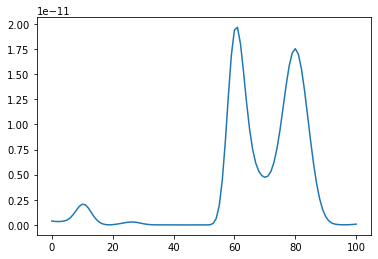

In [1441]:
def adjusted_parameters(parameters, gradient, stepsize):
    new_parameters = []
    for sys in range(len(parameters)):
        new_parameters.append([])
        for para in range(len(parameters[sys])):
            a = parameters[sys][para][3]
            b = stepsize*gradient[sys][para]
            old_val = list(parameters[sys][para])
            new_val = []
            for i in range(len(old_val)-1):
                new_val.append(old_val[i])
            new_val.append(a+b)
            new_parameters[sys].append(tuple(new_val))
            
    return new_parameters

def parameter_based_unitary(parameters,delta):
    U = []
    for p in parameters:
        size = int(math.sqrt(len(p)))
        
        uni = CUE_generator(size, p, delta)
        U.append(uni)
        
    return U


def Y_calculator_wrapper(sep_state_set, rho, U):
    
    Local_unitary_list = [U[n][0] for n in range(len(U))]
    
    Total_U = tensor_product(Local_unitary_list)
    right_tensor_product = tensor_product_right(Local_unitary_list)
    left_tensor_product = tensor_product_left(Local_unitary_list)
    
    Y = Y_Calculator(Sep_state_set, Total_U, rho)
    return Y

def dynamic_stepsize():
    stepsize = 0.1
    return stepsize

def Gradient_Descent(system,rho,delta):
    abs = lambda f:cmath.sqrt(f.real**2+f.imag**2)
    sep_state_set = Seperable_state_set_generator(Mutually_Orthogonal_state_generator(system))

    parameters = []
    
    for n in system:
        size = n
        p = CUE_parameter_generator(size, delta)
        parameters.append(p)
        
    U = parameter_based_unitary(parameters,delta)
    
    Y = Y_calculator_wrapper(sep_state_set, rho, U)
    
    Y_correction = [abs(Y[0]).real]
    
    for i in range(100):
        gradient = Gradient(sep_state_set,rho,unitaries,parameters) 
        nrm = np.linalg.norm(np.array(gradient))
        gradient = gradient/nrm
     
        stepsize = dynamic_stepsize()
        new_parameters = adjusted_parameters(parameters, gradient, stepsize)

        U_new = parameter_based_unitary(new_parameters,delta)
        Y_new = Y_calculator_wrapper(sep_state_set, rho, U_new)
        Y_correction.append(abs(Y_new[0]).real)
        parameters = new_parameters
    
    return Y_correction

system = [3,3]
rho = rand_dm(Hilbert_space_size)
Delta = 1
GD = Gradient_Descent(system,rho,Delta)
# print(GD)
xpoints = np.array(list(range(len(GD))))
ypoints = np.array(GD)

plt.plot(xpoints, ypoints)
plt.show()

In [1301]:
#inputs:
system = [3,3]        

Hilbert_space_size = Series_multiply(system)
rho = rand_dm(Hilbert_space_size)

print(rho)

Gradient_Descent(system,rho)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 1.24312058e-01+0.j          2.62549630e-02-0.00527295j
  -3.02734768e-02+0.00763083j -1.20187886e-02-0.01754226j
   1.00650127e-03-0.04915478j  2.13914274e-02-0.0318073j
  -7.40825671e-03-0.00761101j -6.12432919e-02+0.05308344j
  -4.07598131e-02-0.01803196j]
 [ 2.62549630e-02+0.00527295j  5.42186826e-02+0.j
  -2.00044920e-02-0.0006259j  -5.90017499e-03+0.00832007j
  -2.35694132e-03-0.01543503j -5.76484732e-04-0.00706801j
   1.56621239e-02-0.00286525j -3.09711815e-02+0.03651509j
  -9.02872743e-03+0.01533441j]
 [-3.02734768e-02-0.00763083j -2.00044920e-02+0.0006259j
   5.92920580e-02+0.j         -2.68366232e-02+0.02198093j
   3.08234924e-03+0.02863526j  2.10242735e-02-0.01276878j
   1.46276711e-02-0.01868013j  2.80239831e-02-0.02802179j
  -2.75365474e-03+0.02570862j]
 [-1.20187886e-02+0.01754226j -5.90017499e-03-0.00832007j
  -2.68366232e-02-0.02198093j  1.22477093e-01+0.j
   3.78758185e-02-0.010

UnboundLocalError: local variable 'stepsize' referenced before assignment

In [1354]:
f = np.array([[3,0],[0,4]])
nor = np.linalg.norm(f)
f/nor

array([[0.6, 0. ],
       [0. , 0.8]])

In [1353]:
math.sqrt(2)*0.6

0.848528137423857